<a href="https://colab.research.google.com/github/BrenesRM/Haochen-Mitre-Attack-data-2024/blob/main/Haochen_Mitre_Attack_data_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Definition -

## Library Definition

In [3]:
!pip install numpy scipy matplotlib ipython scikit-learn pandas jupyter tensorflow tensorboard joblib mglearn \
attackcti stix2 nltk seaborn imblearn imbalanced-learn spacy flaml[automl] catboost lightgbm wordcloud

  Using cached jupyter-1.1.1-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached mglearn-0.2.0-py2.py3-none-any.whl.metadata (628 bytes)
  Using cached attackcti-0.5.4-py3-none-any.whl.metadata (4.6 kB)
  Using cached stix2-3.0.1-py2.py3-none-any.whl.metadata (10 kB)
  Using cached imblearn-0.0-py2.py3-none-any.whl.metadata (355 bytes)
  Using cached catboost-1.2.8-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
  Using cached FLAML-2.3.4-py3-none-any.whl.metadata (16 kB)
  Using cached jedi-0.19.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached jupyterlab-4.4.2-py3-none-any.whl.metadata (16 kB)
  Using cached taxii2_client-2.3.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached stix2_patterns-2.0.0-py2.py3-none-any.whl.metadata (8.3 kB)
  Using cached async_lru-2.0.5-py3-none-any.whl.metadata (4.5 kB)
  Using cached jupyter_lsp-2.2.5-py3-none-any.whl.metadata (1.8 kB)
  Using cached jupyter_server-2.16.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached jupyterlab_ser

In [4]:
from attackcti import attack_client
from stix2 import MemoryStore, AttackPattern, Identity, Relationship
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
import pickle

## Present the Data Get Alerts (scraped from open source)

In [8]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your CSV files
base_path = '/content/drive/MyDrive/Colab Notebooks/Data/'

# Load the CSV files
data = pd.read_csv(base_path + 'tagged_alerts.csv')
data.dropna(inplace=True)

alerts = pd.read_csv(base_path + 'alerts.csv')
alerts.dropna(inplace=True)

# Display info
print("Amount of alerts:", len(alerts))
data.head()



Mounted at /content/drive
Amount of alerts: 2279


,id,alert
0,T1001,"This atomic test, named ""Steganographic Tarbal..."
1,T1001,This atomic test demonstrates the technique of...
2,T1003,The memory of lsass.exe is often dumped for of...
3,T1003,The memory of lsass.exe is often dumped for of...
4,T1003,The memory of lsass.exe is often dumped for of...


### Get the Label

Get All MITRE ATT&CK Techniques (id & description) from 'attackcti'






A Python module to access up to date ATT&CK content available in STIX via public TAXII server.

In [9]:
lift = attack_client()
all_techniques = lift.get_techniques()

An Example of MITRE ATT&CK (Label)

In [10]:
all_techniques[0]

AttackPattern(type='attack-pattern', spec_version='2.1', id='attack-pattern--0042a9f5-f053-4769-b3ef-9ad018dfa298', created_by_ref='identity--c78cb6e5-0c4b-4611-8297-d1b8b55e40b5', created='2020-01-14T17:18:32.126Z', modified='2025-04-25T14:45:37.275Z', name='Extra Window Memory Injection', description="Adversaries may inject malicious code into process via Extra Window Memory (EWM) in order to evade process-based defenses as well as possibly elevate privileges. EWM injection is a method of executing arbitrary code in the address space of a separate live process. \n\nBefore creating a window, graphical Windows-based processes must prescribe to or register a windows class, which stipulate appearance and behavior (via windows procedures, which are functions that handle input/output of data).(Citation: Microsoft Window Classes) Registration of new windows classes can include a request for up to 40 bytes of EWM to be appended to the allocated memory of each instance of that class. This EWM

### Make the label understandable

In [11]:
def get_mitre_techniques():
    mitre_techniques_list = []
    for technique in all_techniques:
        if technique['external_references'] and technique['description']:
            for ref in technique['external_references']:
                if 'external_id' in ref and '.' not in ref['external_id']:
                    mitre_techniques_list.append((ref['external_id'], technique['name'],technique.description))
                    break
    return mitre_techniques_list
mitre_techniques = get_mitre_techniques()

mitre_techniques[0]

('T1047',
 'Windows Management Instrumentation',
 'Adversaries may abuse Windows Management Instrumentation (WMI) to execute malicious commands and payloads. WMI is designed for programmers and is the infrastructure for management data and operations on Windows systems.(Citation: WMI 1-3) WMI is an administration feature that provides a uniform environment to access Windows system components.\n\nThe WMI service enables both local and remote access, though the latter is facilitated by [Remote Services](https://attack.mitre.org/techniques/T1021) such as [Distributed Component Object Model](https://attack.mitre.org/techniques/T1021/003) and [Windows Remote Management](https://attack.mitre.org/techniques/T1021/006).(Citation: WMI 1-3) Remote WMI over DCOM operates using port 135, whereas WMI over WinRM operates over port 5985 when using HTTP and 5986 for HTTPS.(Citation: WMI 1-3) (Citation: Mandiant WMI)\n\nAn adversary can use WMI to interact with local and remote systems and use it as a 

Order the Array by TAG

In [14]:
mitre_id = [tech[0] for tech in mitre_techniques]
mitre_id

len(mitre_id)

392

### Get the Description of the TECHNIQUE

In [16]:
mitre_description = [tech[2] for tech in mitre_techniques]
mitre_description

len(mitre_description)

392

## Use nltk to process label

The Natural Language Toolkit, or more commonly NLTK, is a suite of libraries and programs for symbolic and statistical natural language processing (NLP) for English written in the Python programming language. It supports classification, tokenization, stemming, tagging, parsing, and semantic reasoning functionalities.

In [18]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('stopwords')

#for example
text = mitre_description[1][:100]
tokens = word_tokenize(text.lower())
filtered_tokens = [word for word in tokens if word not in stopwords.words('english')]

print("Original Tokens:", tokens)
print("Filtered Tokens:", filtered_tokens)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Original Tokens: ['adversaries', 'may', 'attempt', 'to', 'take', 'screen', 'captures', 'of', 'the', 'desktop', 'to', 'gather', 'information', 'over', 'the', 'course']
Filtered Tokens: ['adversaries', 'may', 'attempt', 'take', 'screen', 'captures', 'desktop', 'gather', 'information', 'course']


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Create an attack_pattern as an object to present label

Structured Threat Information Expression (STIX) is a language and serialization format used to exchange cyber threat intelligence (CTI).

STIX is open source.

from stix2 import AttackPattern

### attack_pattern = AttackPattern(name="T1234", description="Description of T1234")

In [19]:
attack_patterns = []
for id, description in zip(mitre_id, mitre_description):
    attack_pattern = AttackPattern(name=id, description=description)
    attack_patterns.append(attack_pattern)
vectorizer = TfidfVectorizer(stop_words='english')
descriptions_tfidf = vectorizer.fit_transform([ap.description for ap in attack_patterns])

##@ Try analyze an alerts base on attack_pattern

In [20]:
def match_alert_to_mitre(alert):
    alert_tfidf = vectorizer.transform([alert])
    cosine_sim = cosine_similarity(alert_tfidf, descriptions_tfidf)
    max_index = cosine_sim.argmax()
    return attack_patterns[max_index].name
sample_alert = "Detected an anomaly in network traffic that suggests a potential data exfiltration attempt."
matched_id = match_alert_to_mitre(sample_alert)
print(f"The alert matches MITRE ATT&CK Technique ID: {matched_id}")

The alert matches MITRE ATT&CK Technique ID: T1029


In [21]:
alert='Adversaries may interact with the Windows Registry to gather information about the system, configuration, and installed software'

print(f"The alert matches MITRE ATT&CK Technique ID: {match_alert_to_mitre(alert)}")

The alert matches MITRE ATT&CK Technique ID: T1012


Implement this model on our dataset

In [22]:
descriptions = data['alert'].tolist()
true_labels = data['id'].tolist()

descriptions_train, descriptions_test, labels_train, labels_test = train_test_split(
    descriptions, true_labels, test_size=0.2, random_state=42)

descriptions_tfidf = vectorizer.fit_transform(descriptions_train)

## Before the Evaluation (check the distribution of test labels with the size of confusion matrix)

In [23]:
def match_alert_to_mitre(alert, vectorizer, descriptions_tfidf, labels_train):
    alert_tfidf = vectorizer.transform([alert])
    cosine_sim = cosine_similarity(alert_tfidf, descriptions_tfidf)
    max_index = cosine_sim.argmax()
    return labels_train[max_index]

predictions = [match_alert_to_mitre(alert, vectorizer, descriptions_tfidf, labels_train) for alert in
               descriptions_test]

unique, counts = np.unique(labels_test, return_counts=True)
print(dict(zip(unique, counts)))
cm = confusion_matrix(labels_test, predictions)
print("Confusion Matrix shape:", cm.shape)
unique_train_labels = np.unique(labels_train)
unique_test_labels = np.unique(labels_test)
print(f"Count of unique labels in training set: {len(unique_train_labels)}")
print(f"Count of unique labels in test set: {len(unique_test_labels)}")

{np.str_('T1003'): np.int64(8), np.str_('T1005'): np.int64(1), np.str_('T1007'): np.int64(1), np.str_('T1012'): np.int64(2), np.str_('T1014'): np.int64(1), np.str_('T1016'): np.int64(3), np.str_('T1018'): np.int64(2), np.str_('T1021'): np.int64(3), np.str_('T1027'): np.int64(4), np.str_('T1030'): np.int64(1), np.str_('T1033'): np.int64(1), np.str_('T1037'): np.int64(1), np.str_('T1039'): np.int64(1), np.str_('T1040'): np.int64(3), np.str_('T1046'): np.int64(1), np.str_('T1047'): np.int64(2), np.str_('T1048'): np.int64(3), np.str_('T1053'): np.int64(6), np.str_('T1055'): np.int64(5), np.str_('T1056'): np.int64(3), np.str_('T1057'): np.int64(1), np.str_('T1059'): np.int64(9), np.str_('T1069'): np.int64(7), np.str_('T1070'): np.int64(19), np.str_('T1071'): np.int64(2), np.str_('T1078'): np.int64(1), np.str_('T1082'): np.int64(12), np.str_('T1083'): np.int64(1), np.str_('T1087'): np.int64(4), np.str_('T1095'): np.int64(1), np.str_('T1098'): np.int64(4), np.str_('T1105'): np.int64(8), np.st

Evaluate this Model

In [24]:
#accuracy

correct_predictions = sum(1 for true, pred in zip(labels_test, predictions) if true == pred)
accuracy = correct_predictions / len(labels_test)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.62


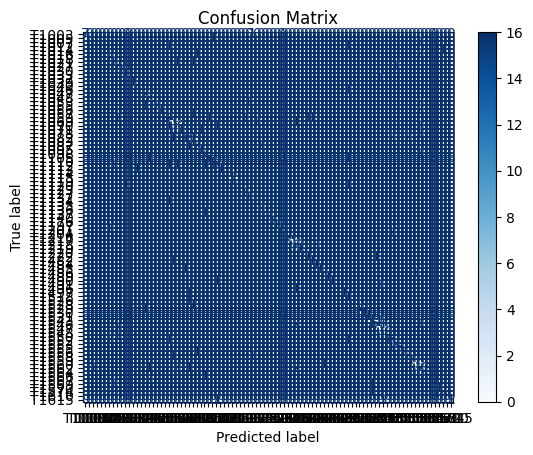

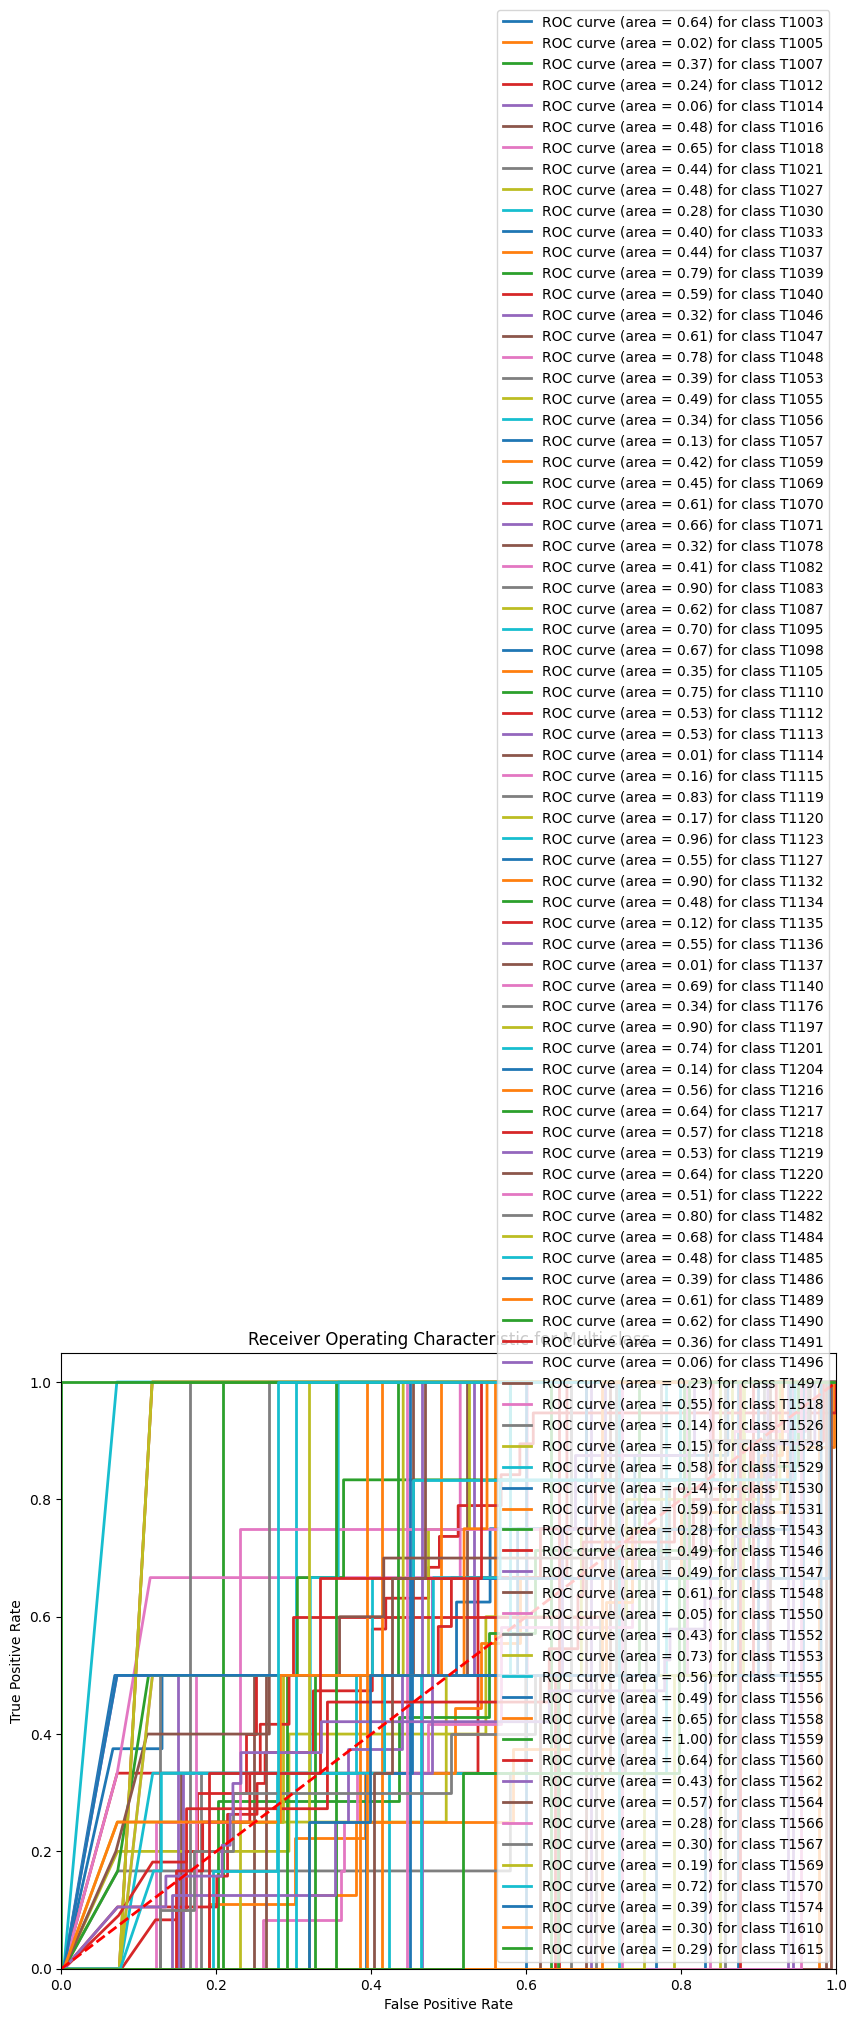

AUC for class T1003: 0.64
AUC for class T1005: 0.02
AUC for class T1007: 0.37
AUC for class T1012: 0.24
AUC for class T1014: 0.06
AUC for class T1016: 0.48
AUC for class T1018: 0.65
AUC for class T1021: 0.44
AUC for class T1027: 0.48
AUC for class T1030: 0.28
AUC for class T1033: 0.40
AUC for class T1037: 0.44
AUC for class T1039: 0.79
AUC for class T1040: 0.59
AUC for class T1046: 0.32
AUC for class T1047: 0.61
AUC for class T1048: 0.78
AUC for class T1053: 0.39
AUC for class T1055: 0.49
AUC for class T1056: 0.34
AUC for class T1057: 0.13
AUC for class T1059: 0.42
AUC for class T1069: 0.45
AUC for class T1070: 0.61
AUC for class T1071: 0.66
AUC for class T1078: 0.32
AUC for class T1082: 0.41
AUC for class T1083: 0.90
AUC for class T1087: 0.62
AUC for class T1095: 0.70
AUC for class T1098: 0.67
AUC for class T1105: 0.35
AUC for class T1110: 0.75
AUC for class T1112: 0.53
AUC for class T1113: 0.53
AUC for class T1114: 0.01
AUC for class T1115: 0.16
AUC for class T1119: 0.83
AUC for clas

In [25]:
missing_in_test = np.setdiff1d(unique_train_labels, unique_test_labels)
cm = confusion_matrix(labels_test, predictions, labels=unique_test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_test_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


n_classes = len(unique_test_labels)
labels_test_bin = label_binarize(labels_test, classes=unique_test_labels)
predictions_bin = label_binarize(predictions, classes=unique_test_labels)

similarity_scores = []
for alert in descriptions_test:
    alert_tfidf = vectorizer.transform([alert])
    cosine_sim = cosine_similarity(alert_tfidf, descriptions_tfidf)
    similarity_scores.append(cosine_sim.max())

similarity_scores = np.array(similarity_scores)

# roc
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(labels_test_bin[:, i], similarity_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc, unique_test_labels[i]))

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-class')
plt.legend(loc='lower right')
plt.show()

# auc
for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(labels_test_bin[:, i], similarity_scores)
    roc_auc = auc(fpr, tpr)
    print(f'AUC for class {unique_test_labels[i]}: {roc_auc:.2f}')

### TOP 5 AUC and ROC

Top 5 AUC Classes:
Class: T1559, AUC: 1.00
Class: T1123, AUC: 0.96
Class: T1083, AUC: 0.90
Class: T1132, AUC: 0.90
Class: T1197, AUC: 0.90


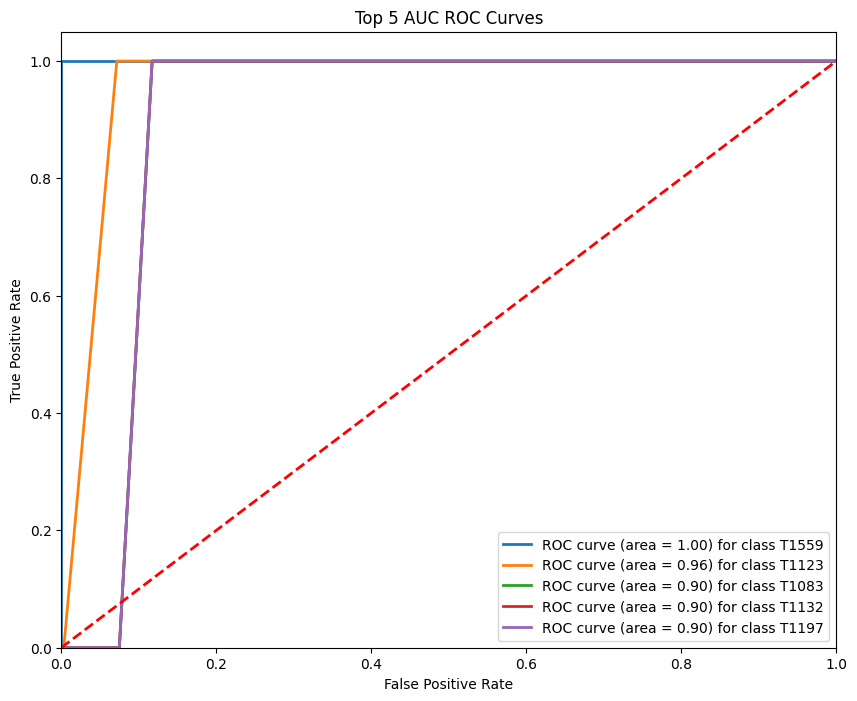

In [26]:
auc_per_class = []
similarity_scores = np.array(similarity_scores)  # make sure similarity_scores is numpy array

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(labels_test_bin[:, i], similarity_scores)
    roc_auc = auc(fpr, tpr)
    auc_per_class.append((unique_test_labels[i], roc_auc))

# auc top 5
top_5_auc = sorted(auc_per_class, key=lambda x: x[1], reverse=True)[:5]

print("Top 5 AUC Classes:")
for label, auc_value in top_5_auc:
    print(f'Class: {label}, AUC: {auc_value:.2f}')

top_5_auc_labels = [label for label, _ in top_5_auc]
top_5_auc_indices = [list(unique_test_labels).index(label) for label in top_5_auc_labels]

# roc top 5
plt.figure(figsize=(10, 8))
for idx in top_5_auc_indices:
    fpr, tpr, _ = roc_curve(labels_test_bin[:, idx], similarity_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.2f}) for class {unique_test_labels[idx]}')

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Top 5 AUC ROC Curves')
plt.legend(loc='lower right')
plt.show()

Print the Results

In [27]:
results_df = pd.DataFrame({
    'Alert': descriptions_test,
    'True Label': labels_test,
    'Predicted Label': predictions
})
results_df['Correct Prediction'] = results_df['True Label'] == results_df['Predicted Label']
results_df

,Alert,True Label,Predicted Label,Correct Prediction
0,Copy from sensitive File from the c$ of anothe...,T1039,T1039,True
1,RunOnce Key Persistence via PowerShell,T1547,T1547,True
2,This test is intended to be run on a domain Co...,T1003,T1003,True
3,PowerShell Built-in Cmdlets to capture network...,T1040,T1040,True
4,An adversary can modify the group policy setti...,T1484,T1484,True
...,...,...,...,...
303,A Kubernetes secret is an object that lets use...,T1552,T1552,True
304,Delete a single file from the temporary direct...,T1070,T1070,True
305,"In VMWARE ESXi, process names starting with vm...",T1529,T1047,False
306,User Account Control (UAC) is a security mecha...,T1548,T1548,True


## Achieve auto-tagging

In [28]:
alerts.head()

,alert
0,"This search establishes, on a per-hour basis, ..."
1,This search is used to build a Machine Learnin...
2,This search is used to build a Machine Learnin...
3,This search is used to build a Machine Learnin...
4,This search is used to build a Machine Learnin...


In [29]:
def auto_tag_alerts(df, vectorizer, descriptions_tfidf, labels_train):
    df['Predicted MITRE ID'] = df['alert'].apply(lambda x: match_alert_to_mitre(x, vectorizer, descriptions_tfidf, labels_train))
    return df

tagged_df = auto_tag_alerts(alerts, vectorizer, descriptions_tfidf, labels_train)
tagged_df

,alert,Predicted MITRE ID
0,"This search establishes, on a per-hour basis, ...",T1046
1,This search is used to build a Machine Learnin...,T1552
2,This search is used to build a Machine Learnin...,T1552
3,This search is used to build a Machine Learnin...,T1552
4,This search is used to build a Machine Learnin...,T1612
...,...,...
2274,Group-IB Threat Intelligence unit discovered a...,T1560
2275,Utilize searches that enable you to detect and...,T1053
2276,This analytic story provides a collection of a...,T1046
2277,A critical security advisory was released by P...,T1021


## Create a downloadable "Alert & MITRE ATT&CK Technique ID Mapping Machine Learning" Model¶
Based on TF-IDF, nltk, stix2 AttackPattern, Cosine Similarity, RandomForest Machine Learning Model

In [ ]:
# splited in previous "Implement this model on our dataset" section
descriptions = data['alert']
true_labels = data['id']
descriptions_train, descriptions_test, labels_train, labels_test = train_test_split(
    descriptions, true_labels, test_size=0.2, random_state=42)
vectorizer = TfidfVectorizer(stop_words='english')
descriptions_tfidf = vectorizer.fit_transform(descriptions_train)
descriptions_test_tfidf = vectorizer.transform(descriptions_test)

#cosine silimarity
cos_sim_train = cosine_similarity(descriptions_tfidf, descriptions_tfidf)
cos_sim_test = cosine_similarity(descriptions_test_tfidf, descriptions_tfidf)

#X and y
X_train = np.hstack([descriptions_tfidf.toarray(), cos_sim_train])
X_test = np.hstack([descriptions_test_tfidf.toarray(), cos_sim_test])
y_train = np.array(labels_train)
y_test = np.array(labels_test)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)


#randonforest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

stratified_kfold = StratifiedKFold(n_splits=3)

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid,
                           cv=stratified_kfold, n_jobs=-1, verbose=2, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

best_rf_model = grid_search.best_estimator_
y_pred = best_rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Tuned Random Forest Model accuracy: {accuracy:.4f}")

#save the model
model_filename = 'current_best_model.pkl'
with open(model_filename, 'wb') as model_file:
    pickle.dump({
        'model': best_rf_model,
        'vectorizer': vectorizer
    }, model_file)

print(f"Model saved to {model_filename}.")